<center><h2>Cellular Automata Traffic Simulation and Analysis based on Fundamental Diagrams</h2></center>

<div align ='right'>Date: 18/04/2023</div>  
<div align ='right'>Name: Hou Hin Ip (Izaac Ip)</div>   

<b><h1>Table of Content</h1></b>

* 1. [Preparation](#P)
* 2. [Models Setup](#MS)  
    * 2.1. [One-space model and Two-space model](#MS_OMATM)  
    * 2.2. [Multi-vehicle Model](#MS_MM)  
    * 2.3. [Nagel-Schreckenberg Model](#MS_NM)  
* 3. [Analysis Plots](#AP)  
    * 3.1. [One-space Model](#AP_OM)
        * 3.1.1. [Fundamental Diagram](#AP_OM_FD)  
        * 3.1.2. [Velocity vs Density Diagram](#AP_OM_VVDD)  
    * 3.2. [Two-space Model](#AP_TM)
        * 3.2.1. [Fundamental Diagram](#AP_TM_FD)  
        * 3.2.2. [Velocity vs Density Diagram](#AP_TM_VVDD)  
    * 3.3. [Multi-vehicle Model](#AP_MM)
        * 3.3.1. [Fundamental Diagram](#AP_MM_FD)  
        * 3.3.2. [Density, Flow, Velocity vs Number of Buses](#AP_MM_DFVVNOB)  
        * 3.3.3. [Car Density vs Vehicle Density](#AP_MM_CDVVD)
    * 3.4. [NaSch Model](#AP_NM)
        * 3.4.1. [Fundamental Diagram](#AP_NM_FD)  

<a id='P'>
<h1>1. Preparation</h1>
</a>

In [1]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

In [2]:
def mean_square_error(data_a, data_b):
    '''
    data_a: 1D array
    data_b: 1D array
    '''

    if len(data_a) != len(data_b):
        raise ValueError("The length of the two array should be the same!")

    mse = 0
    for i in range(len(data_a)):
        mse += (data_a[i] - data_b[i]) ** 2
    mse = mse / len(data_a)

    return mse


def decision(prob):
    '''
    prob: float, the probability return True, else return False
    '''
    return random.random() < prob

<a id='MS'>
<h1>2. Models Setup</h1>
</a>

<a id='MS_OMATM'>
<h2>2.1. One-space Model and Two-space model</h2>
</a>

In [3]:
class k_space_model:
    def __init__(self, length: int, vehicle_num: int, k=1):
        # Check for ValueError
        if length < vehicle_num:
            raise ValueError("Road Length should not be smaller than the number of vehicles!")

        if vehicle_num <= 0:
            raise ValueError("There should be at least one vehicle for simulations!")

        if length <= 0:
            raise ValueError("Road length should be a positive integer!")

        self.length = length
        self.vehicle_num = vehicle_num
        self.need_space = k

        # Initialize the road
        self.road = np.zeros(length)
        self.init_track()

        # Initialize data
        self.init_data()

    def init_track(self):
        # Initialize vehicle positions randomly
        vehicle_pos = np.random.choice(range(self.length), self.vehicle_num, replace=False)
        self.road[vehicle_pos] = 1

        # Reshape the road to be a 2D array
        self.road = self.road.reshape(1, self.length)

        # Randomly choose cells for density, flow, and velocity measurements
        self.density_site = random.randint(0, self.length - 1)
        self.flow_site = random.randint(0, self.length - 1)
        self.velocity_site = random.randint(0, self.length - 1)

    def init_data(self):
        # Initialize sample data
        self.sample_density = []
        self.sample_flow = []
        self.sample_velocity = []

        # Initialize system data
        self.system_density = self.vehicle_num / self.length
        self.system_flow = []
        self.system_velocity = []

    def update(self, road):
        new_road = np.zeros(self.length)
        moved_vehicle = 0

        flow_counter = 0
        real_speed_array = []

        # Simulate for new road
        for cur_pos in range(self.length):
            # If there is a car
            if road[cur_pos] == 1:

                can_move = True
                # Check if there is enough space to move
                for i in range(1, self.need_space + 1):
                    if road[(cur_pos + i) % self.length] != 0:
                        can_move = False

                # If enough space is given, the vehicle move
                if can_move:
                    # Move one space forward
                    new_road[(cur_pos + 1) % self.length] = 1
                    moved_vehicle += 1

                    # Count for sample flow
                    if cur_pos == self.flow_site:
                        flow_counter += 1

                else:
                    # If no space, stay still
                    new_road[cur_pos] = 1

                # Count for sample velocity
                if cur_pos == self.velocity_site or cur_pos + 1 == self.velocity_site:
                    real_speed_array.append(1 if can_move else 0)

        density_counter = 1 if new_road[self.density_site] == 1 else 0

        # Update data
        self.sample_density.append(density_counter)
        self.sample_flow.append(flow_counter)
        self.sample_velocity.extend(real_speed_array)

        self.system_flow.append(moved_vehicle / self.length)
        self.system_velocity.append(moved_vehicle / self.vehicle_num)

        return new_road

    def simulate(self, steps=200):
        if steps <= 0:
            raise ValueError("Number of total steps should be a positive integer!")

        self.steps = steps

        for i in range(steps):
            # Simulate the road for one step
            new_road = self.update(self.road[i])
            # Save the result
            self.road = np.append(self.road, new_road).reshape(i + 2, self.length)

    def return_system_data(self):
        # Return system data
        system_density = self.system_density
        system_flow = np.mean(self.system_flow)
        system_velocity = np.mean(self.system_velocity)

        return system_density, system_flow, system_velocity

    def return_sample_data(self):
        # Return sample data
        sample_density = np.mean(self.sample_density)
        sample_flow = np.mean(self.sample_flow)
        sample_velocity = np.mean(self.sample_velocity)

        return sample_density, sample_flow, sample_velocity

    def print_road(self):
        # Print the final state of the road
        print("\nFinal Result of Road")
        for i in range(self.road.shape[0]):
            print(f"Step {i:2}:", end=' ')
            print(self.road[i])

    def display(self):
        '''
        Display the simulation result as a heatmap.
        '''
        # Get total_steps and road_len
        total_steps, road_len = self.road.shape
        total_steps -= 1  # The first line is initialize state, so deduct one

        fig, ax = plt.subplots(figsize=(8, 8))

        cmap = plt.cm.binary  # Prepare color map as binary

        im = ax.imshow(self.road, cmap=cmap)

        # Set Major ticks
        ax.set_xticks(np.arange(0, road_len, 1))
        ax.set_yticks(np.arange(0, total_steps + 1, 1))

        # Make label based on major ticks
        ax.set_xticklabels(np.arange(1, road_len + 1, 1))
        ax.set_yticklabels(np.arange(0, total_steps + 1, 1))

        # Set Minor ticks
        ax.set_xticks(np.arange(-.5, road_len, 1), minor=True)
        ax.set_yticks(np.arange(-.5, total_steps + 1, 1), minor=True)

        # Set grid based on minor ticks
        ax.grid(which='minor', color='grey', linestyle='-', linewidth=2)

        # Set legend
        labels = {0: 'Empty', 1: 'Occupied'}

        patches = [mpatches.Patch(color=cmap(i * cmap.N), label=labels[i]) for i in [0, 1]]

        fig.legend(handles=patches, loc='right', facecolor='grey')

        # Set title and label
        if self.need_space == 1:
            ax.set_title("One-space Model Simulation")
        elif self.need_space == 2:
            ax.set_title("Two-space Model Simulation")
        ax.set_xlabel("Road (Cells)")
        ax.set_ylabel("Time Step")
        plt.show()


Final Result of Road
Step  0: [0. 1. 0. 0. 1. 0. 1. 1. 0. 0.]
Step  1: [0. 0. 1. 0. 0. 1. 1. 0. 1. 0.]
Step  2: [0. 0. 0. 1. 0. 1. 0. 1. 0. 1.]
Step  3: [1. 0. 0. 0. 1. 0. 1. 0. 1. 0.]
Step  4: [0. 1. 0. 0. 0. 1. 0. 1. 0. 1.]
Step  5: [1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
Step  6: [0. 1. 0. 1. 0. 0. 0. 1. 0. 1.]
Step  7: [1. 0. 1. 0. 1. 0. 0. 0. 1. 0.]
Step  8: [0. 1. 0. 1. 0. 1. 0. 0. 0. 1.]
Step  9: [1. 0. 1. 0. 1. 0. 1. 0. 0. 0.]
Step 10: [0. 1. 0. 1. 0. 1. 0. 1. 0. 0.]


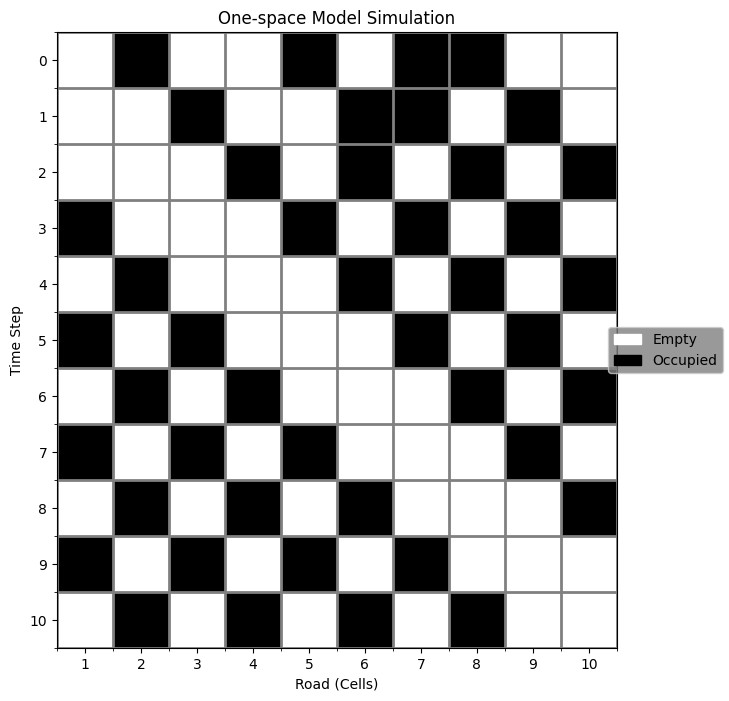

In [4]:
length = 10
vehicle_num = 4
total_steps = 10

model = k_space_model(length, vehicle_num, k=1)
model.simulate(steps=total_steps)
model.print_road()
model.display()

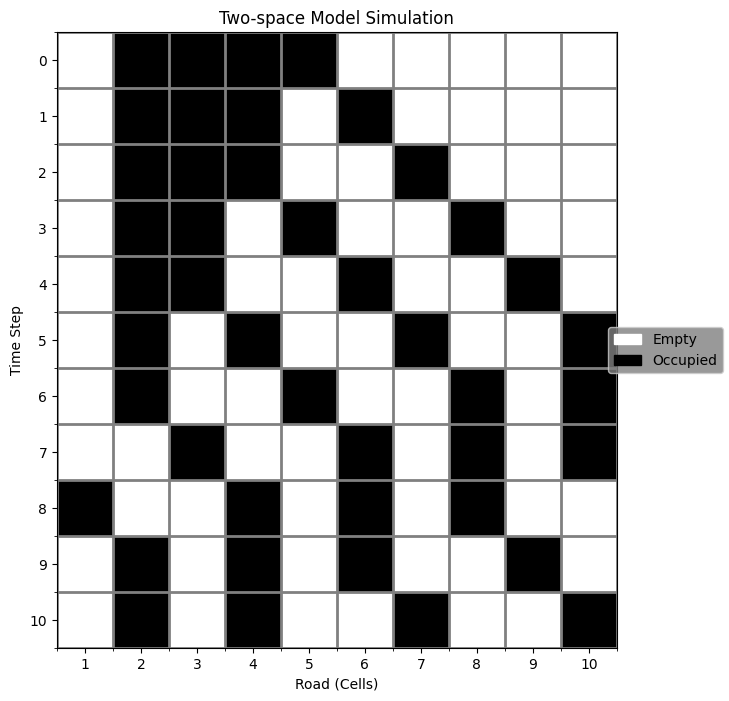

In [5]:
length = 10
vehicle_num = 4
total_steps = 10

model = k_space_model(length, vehicle_num, k=2)
model.simulate(steps=total_steps)
model.display()

<a id='MS_MM'>
<h2>2.2. Multi-vehicle Model</h2>
</a>

In [6]:
class multi_vehicle_model:
    def __init__(self, length: int, car_num: int, bus_num: int):
        # Check for errors in input values
        if length < car_num + bus_num:
            raise ValueError("Road Length should not be smaller than the number of vehicles!")

        if car_num + bus_num <= 0:
            raise ValueError("There should be at least one vehicle for simulations!")

        if length <= 0:
            raise ValueError("Road length should be a positive integer!")

        self.length = length
        self.car_num = car_num
        self.bus_num = bus_num

        self.road = np.zeros(length)
        self.init_track()
        self.init_data()

    def init_track(self):
        # Initialize vehicle positions randomly
        init_pos = np.random.choice(range(self.length), self.car_num + self.bus_num, replace=False)

        # Set index for cars first, then set index for buses
        for i in range(len(init_pos)):
            self.road[init_pos[i]] = 1 if i < self.car_num else 2

        # Randomly choose positions for flow, density, and velocity measurements
        self.flow_site = random.randint(0, self.length - 1)
        self.density_site = random.randint(0, self.length - 1)
        self.velocity_site = random.randint(0, self.length - 1)

        # Reshape the road to be a 2D array
        self.road = self.road.reshape(1, self.length)

    def init_data(self):
        # Initialize sample data
        self.sample_density = []
        self.sample_flow = []
        self.sample_velocity = []

        # Calculate system data
        self.system_density = (self.car_num + self.bus_num) / self.length
        self.system_flow = []
        self.system_velocity = []

    def update(self, road):
        new_road = np.zeros(self.length)
        moved_vehicle = 0

        flow_counter = 0
        real_speed_array = []

        # Simulate for new road
        for cur_pos in range(self.length):
            # If there is a car
            if road[cur_pos] == 1:

                # Check if there is space in front to move
                can_move = road[(cur_pos + 1) % self.length] == 0
                # Check for one space at the front
                if can_move:
                    # Move one space forward
                    new_road[(cur_pos + 1) % self.length] = 1
                    moved_vehicle += 1

                    # Count for sample flow
                    if cur_pos == self.flow_site:
                        flow_counter += 1

                else:
                    # If no space, stay still
                    new_road[cur_pos] = 1

                # Count for sample velocity
                if cur_pos == self.velocity_site or cur_pos + 1 == self.velocity_site:
                    real_speed_array.append(1 if can_move else 0)

                    # If there is a bus
            elif road[cur_pos] == 2:

                # Check if there are two spaces in front to move
                can_move = road[(cur_pos + 1) % self.length] == 0 and road[(cur_pos + 2) % self.length] == 0
                # Check for two spaces at the front
                if can_move:
                    # Move one space forward
                    new_road[(cur_pos + 1) % self.length] = 2
                    moved_vehicle += 1

                    # Count for sample flow
                    if cur_pos == self.flow_site:
                        flow_counter += 1
                else:
                    # If no spaces, stay still
                    new_road[cur_pos] = 2

                # Count for sample velocity
                if cur_pos == self.velocity_site or cur_pos + 1 == self.velocity_site:
                    real_speed_array.append(1 if can_move else 0)

        density_counter = 1 if new_road[self.density_site] != 0 else 0

        # Update data
        self.sample_density.append(density_counter)
        self.sample_flow.append(flow_counter)
        self.sample_velocity.extend(real_speed_array)

        self.system_flow.append(moved_vehicle / self.length)
        self.system_velocity.append(moved_vehicle / (self.car_num + self.bus_num))

        return new_road

    def simulate(self, steps=200):
        if steps <= 0:
            raise ValueError("Number of total steps should be a positive integer!")

        for i in range(steps):
            # Simulate the road for one step
            new_road = self.update(self.road[i])

            # Save the result
            self.road = np.append(self.road, new_road).reshape(i + 2, self.length)

    def return_system_data(self):
        # Return system data
        system_density = self.system_density
        system_flow = np.mean(self.system_flow)
        system_velocity = np.mean(self.system_velocity)

        return system_density, system_flow, system_velocity

    def return_sample_data(self):
        # Return sample data
        sample_density = np.mean(self.sample_density)
        sample_flow = np.mean(self.sample_flow)
        sample_velocity = np.mean(self.sample_velocity)

        return sample_density, sample_flow, sample_velocity

    def print_road(self):
        # Print the final state of the road
        print("\nFinal Result of Road")
        for i in range(self.road.shape[0]):
            print(f"Step {i:2}:", end=' ')
            print(self.road[i])

    def display(self):
        # Get total_steps and road_len
        total_steps, road_len = self.road.shape
        total_steps -= 1  # Road_arrays included step 0, which is not included in total_steps

        # Plot road_arrays
        fig, ax = plt.subplots(figsize=(9, 9))

        cmap = ListedColormap(["white", "red", "blue"])

        im = ax.imshow(self.road, cmap=cmap)

        # Set Major ticks
        ax.set_xticks(np.arange(0, road_len, 1))
        ax.set_yticks(np.arange(0, total_steps + 1, 1))

        # Make label base on major ticks
        ax.set_xticklabels(np.arange(1, road_len + 1, 1))
        ax.set_yticklabels(np.arange(0, total_steps + 1, 1))

        # Set Minor ticks
        ax.set_xticks(np.arange(-.5, road_len, 1), minor=True)
        ax.set_yticks(np.arange(-.5, total_steps + 1, 1), minor=True)

        # Make grid based on minor ticks
        ax.grid(which='minor', color='grey', linestyle='-', linewidth=2)

        # Set legend
        labels = {0: 'Empty', 1: 'Car', 2: 'Bus'}

        patches = [mpatches.Patch(color=cmap(i), label=labels[i]) for i in [0, 1, 2]]

        fig.legend(handles=patches, loc='right', facecolor='grey')

        # Set title and label
        ax.set_title("Multi-vehicle Model Simulation")
        ax.set_xlabel("Road (Cells)")
        ax.set_ylabel("Time Step")
        plt.show()


Final Result of Road
Step  0: [2. 0. 0. 0. 0. 2. 0. 1. 0. 2. 2. 0. 2. 0. 0. 2. 1. 0. 0. 0.]
Step  1: [0. 2. 0. 0. 0. 2. 0. 0. 1. 2. 2. 0. 0. 2. 0. 2. 0. 1. 0. 0.]
Step  2: [0. 0. 2. 0. 0. 0. 2. 0. 1. 2. 0. 2. 0. 2. 0. 2. 0. 0. 1. 0.]
Step  3: [0. 0. 0. 2. 0. 0. 2. 0. 1. 2. 0. 2. 0. 2. 0. 0. 2. 0. 0. 1.]
Step  4: [1. 0. 0. 0. 2. 0. 2. 0. 1. 2. 0. 2. 0. 0. 2. 0. 0. 2. 0. 0.]
Step  5: [0. 1. 0. 0. 2. 0. 2. 0. 1. 2. 0. 0. 2. 0. 0. 2. 0. 0. 2. 0.]
Step  6: [0. 0. 1. 0. 2. 0. 2. 0. 1. 0. 2. 0. 0. 2. 0. 0. 2. 0. 0. 2.]
Step  7: [2. 0. 0. 1. 2. 0. 2. 0. 0. 1. 0. 2. 0. 0. 2. 0. 0. 2. 0. 0.]
Step  8: [0. 2. 0. 1. 2. 0. 0. 2. 0. 0. 1. 0. 2. 0. 0. 2. 0. 0. 2. 0.]
Step  9: [0. 2. 0. 1. 0. 2. 0. 0. 2. 0. 0. 1. 0. 2. 0. 0. 2. 0. 0. 2.]
Step 10: [0. 2. 0. 0. 1. 0. 2. 0. 0. 2. 0. 0. 1. 0. 2. 0. 0. 2. 0. 2.]
Step 11: [0. 0. 2. 0. 0. 1. 0. 2. 0. 0. 2. 0. 0. 1. 0. 2. 0. 2. 0. 2.]
Step 12: [2. 0. 0. 2. 0. 0. 1. 0. 2. 0. 0. 2. 0. 0. 1. 2. 0. 2. 0. 0.]
Step 13: [0. 2. 0. 0. 2. 0. 0. 1. 0. 2. 0. 0. 2. 0. 1. 

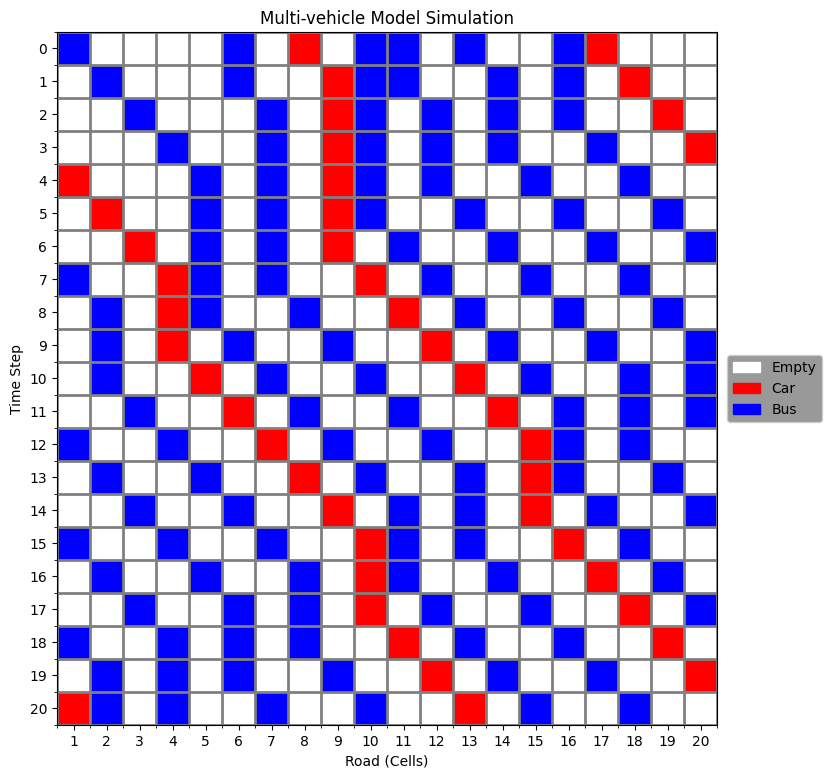

In [7]:
length = 20
vehicle_num = 2
bus_num = 6
total_steps = 20

model = multi_vehicle_model(length, vehicle_num, bus_num)
model.simulate(steps=total_steps)
model.print_road()
model.display()

<a id='MS_NM'>
<h2>2.3. Nagel-Schreckenberg Model</h2>
</a>

In [8]:
class NaSch_model:
    def __init__(self, length: int, vehicle_num: int, vmax=6, prob=0.2):
        # Check for ValueError
        if length < vehicle_num:
            raise ValueError("Road Length should not be smaller than the number of vehicles!")

        if vehicle_num <= 0:
            raise ValueError("There should be at least one vehicle for simulations!")

        if length <= 0:
            raise ValueError("Road length should be a positive integer!")

        self.length = length
        self.vehicle_num = vehicle_num
        self.vmax = vmax
        self.prob = prob

        self.road = np.full(length, -1)  # Initialize road with -1 indicating empty spaces
        self.init_track()
        self.init_data()

    def init_track(self):
        # Initialize car positions randomly
        car_pos = np.random.choice(range(self.length), self.vehicle_num, replace=False)

        # Assign random velocities to cars
        self.road[car_pos] = random.randint(0, 7, self.vehicle_num)

        # Randomly choose cells for flow, density, and velocity measurements
        self.flow_site = random.randint(0, self.length - 1)
        self.density_site = random.randint(0, self.length - 1)
        self.velocity_site = random.randint(0, self.length - 1)

        # Reshape the road to be a 2D array
        self.road = self.road.reshape(1, self.length)

    def init_data(self):
        # Initialize sample data
        self.sample_density = []
        self.sample_flow = []
        self.sample_velocity = []

        # Calculate system data
        self.system_density = self.vehicle_num / self.length
        self.system_flow = []
        self.system_velocity = []

    def update(self, road):
        new_road = np.copy(road)

        sample_flow_counter = 0
        sample_speed_array = []
        total_speed = 0

        # Simulate for new road
        for cur_pos in range(self.length):

            # If there is a vehicle
            if road[cur_pos] != -1:

                v = int(road[cur_pos])

                # Find the closest vehicle ahead in the next v+1 cells
                vehicle_ahead = -1
                for i in range(1, v + 2):
                    # If there is a vehicle ahead
                    if road[(cur_pos + i) % self.length] != -1:
                        vehicle_ahead = i
                        break

                # Acceleration
                if v < self.vmax:
                    # If no vehicle ahead, speed up
                    if vehicle_ahead == -1:
                        v += 1

                # Slowing down
                if vehicle_ahead != -1 and vehicle_ahead <= v:
                    v = vehicle_ahead - 1

                # Randomization
                if decision(self.prob) and v > 0:
                    v = v - 1

                # Move vehicle
                new_road[cur_pos] = -1
                new_road[(cur_pos + v) % self.length] = v

                # Calculate Real Flow
                if cur_pos <= self.flow_site and cur_pos + v > self.flow_site:
                    sample_flow_counter += 1

                # Calculate Real Speed
                if cur_pos <= self.velocity_site and cur_pos + v >= self.velocity_site:
                    sample_speed_array.append(v)

                # Calculate speed
                total_speed += v

        sample_density_counter = 1 if new_road[self.density_site] != -1 else 0

        # Update data
        self.sample_density.append(sample_density_counter)
        self.sample_flow.append(sample_flow_counter)
        self.sample_velocity.extend(sample_speed_array)

        self.system_flow.append(total_speed / self.length)
        self.system_velocity.append(total_speed / self.vehicle_num)

        return new_road

    def simulate(self, steps=200):
        if steps <= 0:
            raise ValueError("Number of total steps should be a positive integer!")

        self.steps = steps

        for i in range(steps):
            # Simulate the road for one step
            new_road = self.update(self.road[i])

            # Save the result
            self.road = np.append(self.road, new_road).reshape(i + 2, self.length)

    def return_system_data(self):
        # Return system-level data
        system_density = self.system_density
        system_flow = np.mean(self.system_flow)
        system_velocity = np.mean(self.system_velocity)

        return system_density, system_flow, system_velocity

    def return_sample_data(self):
        # Return sample-level data
        sample_density = np.mean(self.sample_density)
        sample_flow = np.mean(self.sample_flow)
        sample_velocity = np.mean(self.sample_velocity)

        return sample_density, sample_flow, sample_velocity

    def print_road(self):
        # Print the final state of the road
        print("\nFinal Result of Road")
        for i in range(self.road.shape[0]):
            print(f"Step {i:2}:", end=' ')
            for j in range(self.road.shape[1]):
                if self.road[i][j] == -1:
                    print(".", end=' ')
                else:
                    print(f"{self.road[i][j]:1}", end=' ')
            print()

    def display(self):
        # Display the road simulation
        fig, ax = plt.subplots()

        for step in range(self.road.shape[0]):
            for site in range(self.road.shape[1]):
                if self.road[step][site] != -1:
                    ax.scatter(site, step, s=1, color="black")

        # Set titles and labels
        ax.set_title("NaSch Model Simulations")
        ax.set_xlabel("Road (Cells)")
        ax.set_ylabel("Time Step")

        ax.invert_yaxis()

In [9]:
NaSchModel = NaSch_model(20, 6)
NaSchModel.simulate(20)
NaSchModel.print_road()


Final Result of Road
Step  0: 4 . 6 . 1 . . . . . 1 . . . . 0 . . 0 . 
Step  1: . 1 . 1 . . 2 . . . . . 2 . . . 1 . 0 . 
Step  2: . . 1 . . 2 . . . 3 . . . . . 3 . 1 . 1 
Step  3: . 2 . 1 . . . . 3 . . . . 4 . 0 . . 1 . 
Step  4: 2 . 1 . 1 . . . . . . . 4 . 1 . 1 . . . 
Step  5: . 1 . 1 . . 2 . . . . . . 1 . 1 . . 2 . 
Step  6: 2 . 1 . . 2 . . . 3 . . . . 1 . . 2 . . 
Step  7: . 1 . . 2 . . . 3 . . . . 4 . . 2 . . 2 
Step  8: . . . 2 . . 2 . . . . . 4 . . 2 . . 2 0 
Step  9: 1 . . . . 2 . . . 3 . . . . 2 . . 2 0 . 
Step 10: . . 2 . . . . . 3 . . . . 4 . . 2 0 . 1 
Step 11: . 2 . . . 3 . . . . . . 4 . 1 . 0 . 1 . 
Step 12: 2 . . . 3 . . . 3 . . . 0 . . 1 0 . . . 
Step 13: . . . 3 . . . 3 . . 2 . . 1 . 0 . 1 . . 
Step 14: . . . . . . 3 . . 2 . 1 . . 1 0 . . . 2 
Step 15: . . 3 . . . . . 2 . 1 . 1 . 0 . 1 . . . 
Step 16: . . . . . 3 . . . 1 . 1 . 1 . 1 . . 2 . 
Step 17: 2 . . . . . . . 3 . 1 . 1 0 . . . 2 . . 
Step 18: . . . 3 . . . . . 1 . 1 0 . 1 . . . . 2 
Step 19: . . 3 . . . . 4 . .

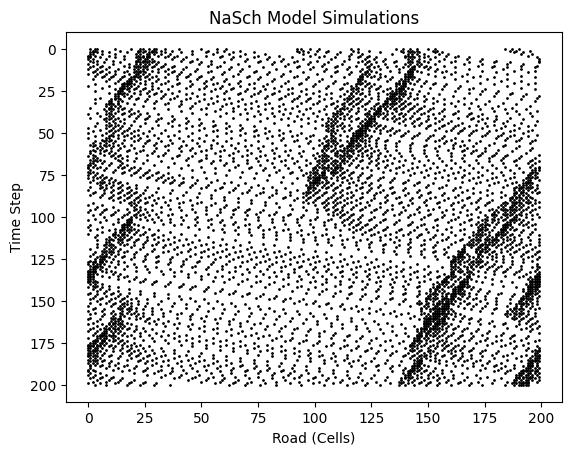

In [10]:
NaSchModel = NaSch_model(200, 30)
NaSchModel.simulate(200)
NaSchModel.display()

<a id='AP'>
<h1>3. Analysis Plots</h1>
</a>

<a id='AP_OM'>
<h2>3.1. One-Space Model</h2>
</a>

<a id='AP_OM_FD'>
<h3>3.1.1. Fundamental Diagram</h3>
</a>

In [11]:
length = 1200
total_steps = 400

# Initialize system data
system_density_array = []
system_flow_array = []
system_velocity_array = []

# Initialize sample data
sample_density_array = []
sample_flow_array = []
sample_velocity_array = []

vehicle_nums = np.arange(1, length + 1)  # Set up list for numbers of vehicles

for i in vehicle_nums:
    # Simulate road
    model = k_space_model(length, i)
    model.simulate(steps=total_steps)

    # Updata system data
    system_density, system_flow, system_velocity = model.return_system_data()
    system_density_array.append(system_density)
    system_flow_array.append(system_flow)
    system_velocity_array.append(system_velocity)

    # Update sample data
    sample_density, sample_flow, sample_velocity = model.return_sample_data()
    sample_density_array.append(sample_density)
    sample_flow_array.append(sample_flow)
    sample_velocity_array.append(sample_velocity)


/Users/houhinip/Documents/University Of Bristol/tb2/Introduction to Coding and Data Analysis for Scientists 2023 TB2/Project4/_Code/python_project_4/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/houhinip/Documents/University Of Bristol/tb2/Introduction to Coding and Data Analysis for Scientists 2023 TB2/Project4/_Code/python_project_4/venv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


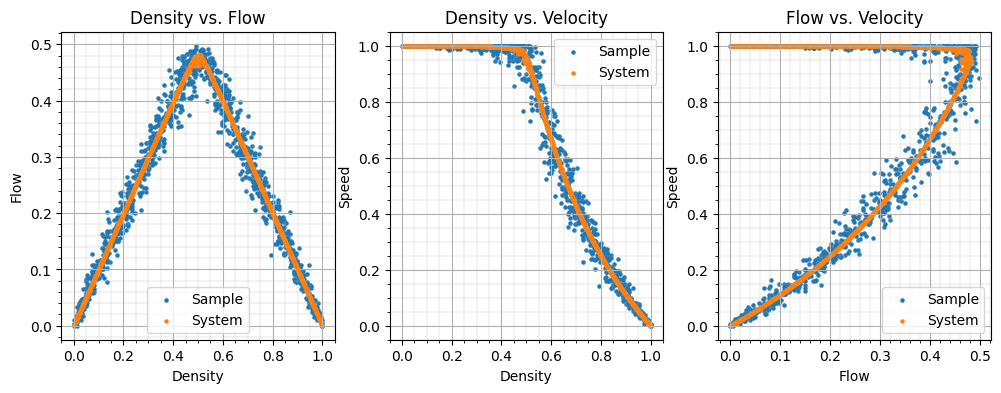

In [12]:
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=3)

ax[0].scatter(sample_density_array, sample_flow_array, s=5, label="Sample")
ax[0].scatter(system_density_array, system_flow_array, s=5, label="System")

# Set titles and labels
ax[0].set_title("Density vs. Flow")
ax[0].set_xlabel("Density")
ax[0].set_ylabel("Flow")

ax[1].scatter(sample_density_array, sample_velocity_array, s=5, label="Sample")
ax[1].scatter(system_density_array, system_velocity_array, s=5, label="System")

# Set titles and labels
ax[1].set_title("Density vs. Velocity")
ax[1].set_xlabel("Density")
ax[1].set_ylabel("Speed")

ax[2].scatter(sample_flow_array, sample_velocity_array, s=5, label="Sample")
ax[2].scatter(system_flow_array, system_velocity_array, s=5, label="System")

# Set titles and labels
ax[2].set_title("Flow vs. Velocity")
ax[2].set_xlabel("Flow")
ax[2].set_ylabel("Speed")

# Set grids, ticks and legends
for i in ax:
    i.grid(which='major')
    i.grid(which='minor', linewidth=0.2)
    i.minorticks_on()
    i.legend()

<a id='AP_OM_VVDD'>
<h3>3.1.2. Velocity vs Density Diagram</h3>
</a>

In [13]:
length = 1200
total_steps = 400

# Initialize data
system_velocity_array = []
system_density_array = []

vehicle_nums = np.arange(1, length + 1)  # Set up list for numbers of vehicles

for i in vehicle_nums:
    # Simulate road
    model = k_space_model(length, i)
    model.simulate(steps=total_steps)

    # Update data
    system_density, system_flow, system_velocity = model.return_system_data()
    system_density_array.append(system_density)
    system_velocity_array.append(system_velocity)

In [14]:
# Find a fitting line
var = np.polyfit(system_density_array, system_velocity_array, 15)
fit_y = np.poly1d(var)

# Calculate maximum vehicle density for 0.9 velocity by the function of fitting line
max_density = (fit_y - 0.9).roots
max_density = max_density[(max_density < 1) & (max_density > 0) & (np.isreal(max_density))]
print(f"Mean square error: {mean_square_error(system_velocity_array, fit_y(system_density_array))}\n")
print(f"Function variables: {var}")

Mean square error: 2.2623508118714113e-05

Function variables: [ 4.78919596e+05 -4.42925806e+06  1.79586518e+07 -4.24246156e+07
  6.52205147e+07 -6.88594294e+07  5.12754380e+07 -2.71978901e+07
  1.02500538e+07 -2.70650836e+06  4.87522558e+05 -5.73521879e+04
  4.10909559e+03 -1.59484660e+02  2.68631051e+00  9.88519535e-01]


Maximum density for average velocity >= 0.9: [0.5185766]



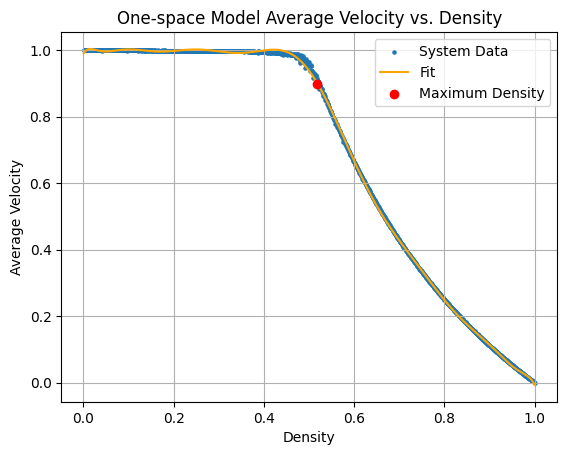

In [15]:
print(f"Maximum density for average velocity >= 0.9: {np.real(max_density)}\n")

# Plot the results
fig, ax = plt.subplots()

ax.scatter(system_density_array, system_velocity_array, label='System Data', s=5, zorder=0)  # Plot original data
ax.plot(system_density_array, fit_y(system_density_array), label='Fit', color="orange", zorder=5)  # Plot fitting line
ax.scatter(np.real(max_density), 0.9, label='Maximum Density', color="red", zorder=10)  # Plot maximum number of vehicles

# Set title, labels, legend and grid
ax.set_title("One-space Model Average Velocity vs. Density")
ax.set_xlabel("Density")
ax.set_ylabel("Average Velocity")
plt.legend(loc="upper right")
plt.grid()

<a id='AP_TM'>
<h2>3.2. Two-Space Model</h2>
</a>

<a id='AP_TM_FD'>
<h3>3.2.1. Fundamental Diagram</h3>
</a>

In [16]:
length = 1200
total_steps = 400

# Initialize system data
system_density_array = []
system_flow_array = []
system_velocity_array = []

# Initialize sample data
sample_density_array = []
sample_flow_array = []
sample_velocity_array = []

vehicle_nums = np.arange(1, length + 1)  # Set up list for numbers of vehicles

for i in vehicle_nums:
    #Simulate road
    model = k_space_model(length, i, k=2)
    model.simulate(steps=total_steps)

    # Update system data
    system_density, system_flow, system_velocity = model.return_system_data()
    system_density_array.append(system_density)
    system_flow_array.append(system_flow)
    system_velocity_array.append(system_velocity)

    # Update sample data
    sample_density, sample_flow, sample_velocity = model.return_sample_data()
    sample_density_array.append(sample_density)
    sample_flow_array.append(sample_flow)
    sample_velocity_array.append(sample_velocity)


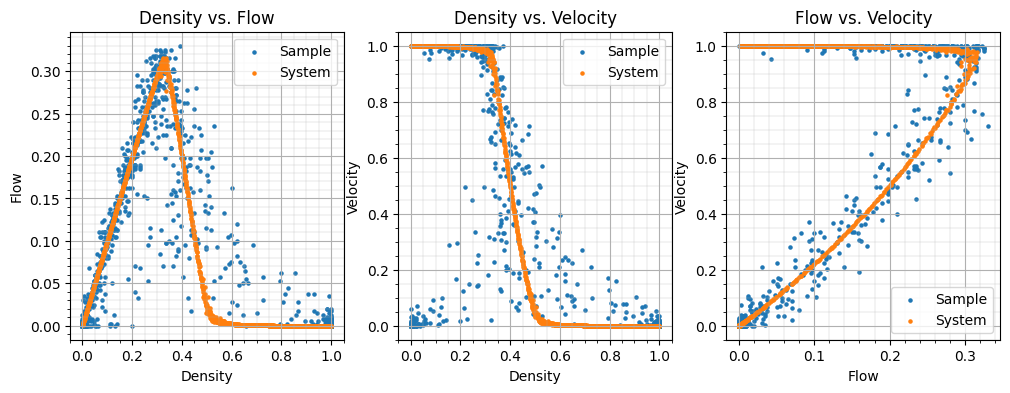

In [17]:
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=3)

ax[0].scatter(sample_density_array, sample_flow_array, s=5, label="Sample")
ax[0].scatter(system_density_array, system_flow_array, s=5, label="System")

# Set titles and labels
ax[0].set_title("Density vs. Flow")
ax[0].set_xlabel("Density")
ax[0].set_ylabel("Flow")

ax[1].scatter(sample_density_array, sample_velocity_array, s=5, label="Sample")
ax[1].scatter(system_density_array, system_velocity_array, s=5, label="System")

# Set titles and labels
ax[1].set_title("Density vs. Velocity")
ax[1].set_xlabel("Density")
ax[1].set_ylabel("Velocity")

ax[2].scatter(sample_flow_array, sample_velocity_array, s=5, label="Sample")
ax[2].scatter(system_flow_array, system_velocity_array, s=5, label="System")

# Set titles and labels
ax[2].set_title("Flow vs. Velocity")
ax[2].set_xlabel("Flow")
ax[2].set_ylabel("Velocity")

# Set grids, ticks and legends
for i in ax:
    i.grid(which='major')
    i.grid(which='minor', linewidth=0.2)
    i.minorticks_on()
    i.legend()

<a id='AP_TM_VVDD'>
<h3>3.2.2. Velocity vs Density Diagram</h3>
</a>

In [18]:
length = 1200
total_steps = 400
bus_nums = np.arange(1, length + 1)

# Initialize data
system_density_array = []
system_velocity_array = []

for i in bus_nums:
    # Simulate road
    model = k_space_model(length, i, k=2)
    model.simulate(steps=total_steps)

    # Update data
    system_density, system_flow, system_velocity = model.return_system_data()
    system_density_array.append(system_density)
    system_velocity_array.append(system_velocity)

In [19]:
# Find a fitting line
var = np.polyfit(system_density_array, system_velocity_array, 25)
fit_y = np.poly1d(var)

# Calculate maximum vehicle density for 0.9 velocity by the function of fitting line
max_density_fast = (fit_y - 0.9).roots
max_density_fast = max_density_fast[(max_density_fast < 1) & (max_density_fast > 0) & (np.isreal(max_density_fast))]

# Calculate maximum vehicle density for 0.01 velocity by the function of fitting line
max_density_slow = (fit_y - 0.01).roots
max_density_slow = max_density_slow[(max_density_slow < 1) & (max_density_slow > 0) & (np.isreal(max_density_slow))]

print(f"Mean square error: {mean_square_error(system_velocity_array, fit_y(system_density_array))}\n")
print(f"Function variables: {var}")

Mean square error: 6.211723266296696e-05

Function variables: [ 5.77870917e+07 -3.15900906e+08  6.11254384e+08 -3.37905639e+08
 -3.54548490e+08  3.21209127e+08  3.35546121e+08 -2.38678483e+08
 -3.58030766e+08  1.57114666e+08  3.63411780e+08 -1.28601608e+08
 -3.41381326e+08  2.05242337e+08  2.29989984e+08 -3.75923639e+08
  2.39985564e+08 -8.74199841e+07  1.90011133e+07 -2.22849095e+06
  6.20953358e+04  1.71490922e+04 -2.17915267e+03  1.00544841e+02
 -1.75289528e+00  1.00715118e+00]


/var/folders/fq/_3b4tsjj5sv_d2gh65lk7ps40000gn/T/ipykernel_68743/2023947285.py:2: RankWarning: Polyfit may be poorly conditioned
  var = np.polyfit(system_density_array, system_velocity_array, 25)


Maximum density for average velocity >= 0.9: [0.33232387]

Maximum density for average velocity >= 0.01: [0.54268249]



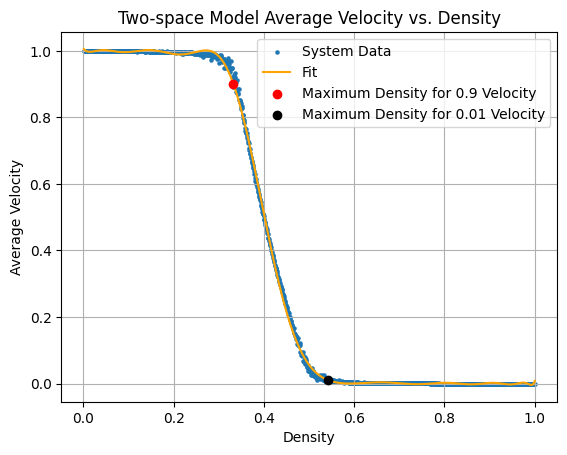

In [20]:
# Plot the results
fig, ax = plt.subplots()

ax.scatter(system_density_array, system_velocity_array, label='System Data', s=5, zorder=0)  # Plot original data
ax.plot(system_density_array, fit_y(system_density_array), label='Fit', color="orange", zorder=5)  # Plot fitting line
ax.scatter(np.real(max_density_fast), 0.9, label='Maximum Density for 0.9 Velocity', color="red",
           zorder=10)  # Plot maximum car number for 0.9 velocity
ax.scatter(np.real(max_density_slow), 0.01, label='Maximum Density for 0.01 Velocity', color="black",
           zorder=10)  # Plot maximum car number for 0.1 velocity

# Set title, labels and legend
ax.set_title("Two-space Model Average Velocity vs. Density")
ax.set_xlabel("Density")
ax.set_ylabel("Average Velocity")
plt.legend(loc="upper right")
plt.grid()

print(f"Maximum density for average velocity >= 0.9: {np.real(max_density_fast)}\n")
print(f"Maximum density for average velocity >= 0.01: {np.real(max_density_slow)}\n")

<a id='AP_MM'>
<h2>3.3. Multi-vehicle Model</h2>
</a>

<a id='AP_MM_FD'>
<h3>3.3.1. Fundamental Diagram</h3>
</a>

In [21]:
length = 1200
total_steps = 400

# Initialize system data
system_density_array = []
system_flow_array = []
system_velocity_array = []

# Initialize sample data
sample_density_array = []
sample_flow_array = []
sample_velocity_array = []

bus_nums = np.arange(1, int(length / 2 + 1))  # Set up list for numbers of buses

for i in bus_nums:
    # Simulate road
    model = multi_vehicle_model(length, i, i)
    model.simulate(steps=total_steps)

    # Update system data
    system_density, system_flow, system_velocity = model.return_system_data()
    system_density_array.append(system_density)
    system_flow_array.append(system_flow)
    system_velocity_array.append(system_velocity)

    # Update sample data
    sample_density, sample_flow, sample_velocity = model.return_sample_data()
    sample_density_array.append(sample_density)
    sample_flow_array.append(sample_flow)
    sample_velocity_array.append(sample_velocity)


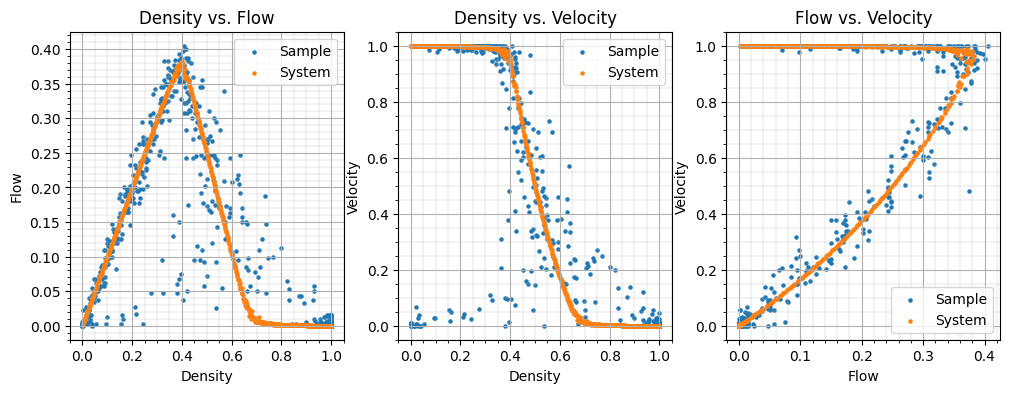

In [22]:
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=3)

ax[0].scatter(sample_density_array, sample_flow_array, s=5, label="Sample")
ax[0].scatter(system_density_array, system_flow_array, s=5, label="System")

# Set titles and labels
ax[0].set_title("Density vs. Flow")
ax[0].set_xlabel("Density")
ax[0].set_ylabel("Flow")

ax[1].scatter(sample_density_array, sample_velocity_array, s=5, label="Sample")
ax[1].scatter(system_density_array, system_velocity_array, s=5, label="System")

# Set titles and labels
ax[1].set_title("Density vs. Velocity")
ax[1].set_xlabel("Density")
ax[1].set_ylabel("Velocity")

ax[2].scatter(sample_flow_array, sample_velocity_array, s=5, label="Sample")
ax[2].scatter(system_flow_array, system_velocity_array, s=5, label="System")

# Set titles and labels
ax[2].set_title("Flow vs. Velocity")
ax[2].set_xlabel("Flow")
ax[2].set_ylabel("Velocity")

# Set grids, ticks and legends
for i in ax:
    i.grid(which='major')
    i.grid(which='minor', linewidth=0.2)
    i.minorticks_on()
    i.legend()

<a id='AP_MM_DFVVNOB'>
<h3>3.3.2. Density, Flow, Velcoity vs Number of Buses</h3>
</a>

In [23]:
total_passengers = 500
car_capacity = 5
bus_capacity = 30
length = 100
total_steps = 100

In [24]:
# Initialize system data
system_density_array = []
system_flow_array = []
system_velocity_array = []

bus_num_array = range(round(total_passengers / bus_capacity))  # Set up list for numbers of buses

for i in bus_num_array:
    # Calculate the number of cars
    bus_num = i
    car_num = int((total_passengers - bus_capacity * bus_num) / car_capacity)

    # Check for invalid value
    if length < bus_num + car_num:
        continue

    # Simulate road
    model = multi_vehicle_model(length, car_num, bus_num)
    model.simulate(total_steps)

    # Update system data
    system_density, system_flow, system_velocity = model.return_system_data()
    system_density_array.append(system_density)
    system_flow_array.append(system_flow)
    system_velocity_array.append(system_velocity)

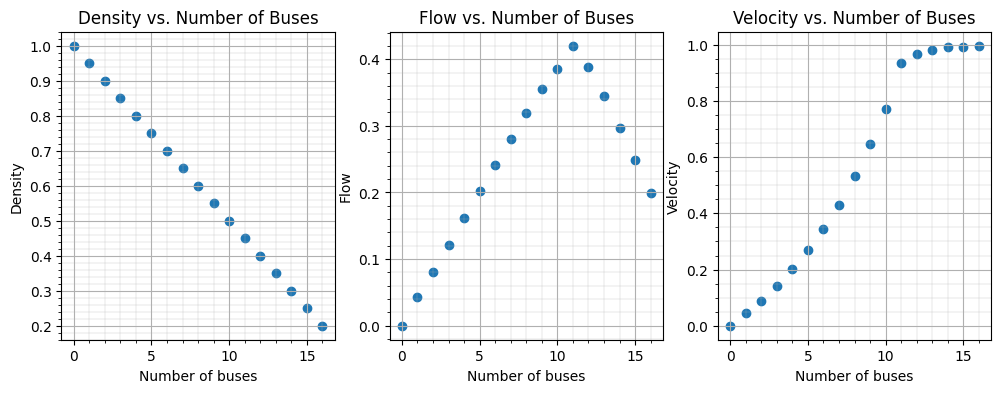

In [25]:
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=3)

ax[0].scatter(bus_num_array, system_density_array)

# Set titles and labels
ax[0].set_title("Density vs. Number of Buses")
ax[0].set_ylabel("Density")

ax[1].scatter(bus_num_array, system_flow_array)

# Set titles and labels
ax[1].set_title("Flow vs. Number of Buses")
ax[1].set_ylabel("Flow")

ax[2].scatter(bus_num_array, system_velocity_array)

# Set titles and labels
ax[2].set_title("Velocity vs. Number of Buses")
ax[2].set_ylabel("Velocity")

# Set xlabels, grids and ticks
for i in ax:
    i.set_xlabel("Number of buses")
    i.grid(which='major')
    i.grid(which='minor', linewidth=0.2)
    i.minorticks_on()

<a id='AP_MM_CDVVD'>
<h3>3.3.3. Car Density vs Vehicle Density</h3>
</a>

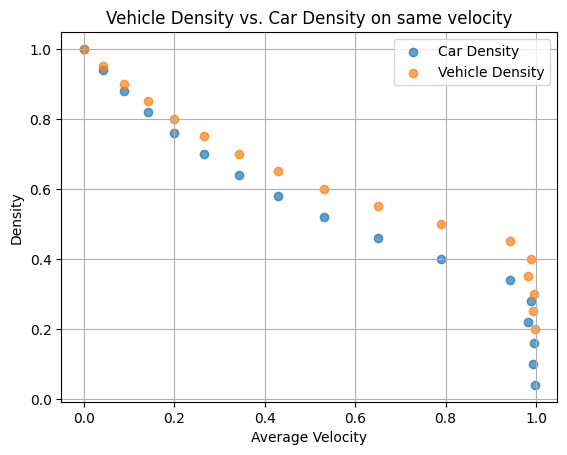

In [26]:
bus_nums = range(round(total_passengers / bus_capacity))  # Set up list for numbers of buses

# Initialize data
system_velocity_array = []
car_density = []
vehicle_density = []

for i in bus_nums:
    # Calculate numbers of cars and buses
    bus_num = i
    car_num = int((total_passengers - bus_capacity * bus_num) / car_capacity)

    # Simulate road
    model = multi_vehicle_model(length, car_num, bus_num)
    model.simulate()

    # Update data
    system_density, system_flow, system_velocity = model.return_system_data()
    system_velocity_array.append(system_velocity)
    car_density.append(car_num / length)
    vehicle_density.append(system_density)

# Plot the result
fig, ax = plt.subplots()
ax.scatter(system_velocity_array, car_density, label="Car Density", alpha=0.7)
ax.scatter(system_velocity_array, vehicle_density, label="Vehicle Density", alpha=0.7)

# Set title, label, legend and grid
ax.set_title("Vehicle Density vs. Car Density on same velocity")
ax.set_xlabel("Average Velocity")
ax.set_ylabel("Density")
plt.legend()
plt.grid()


<a id='AP_NM'>
<h2>3.4. NaSch Model</h2>
</a>

<a id='AP_NM_FD'>
<h3>3.4.1. Fundamental Diagram</h3>
</a>

In [27]:
length = 1200
total_steps = 400

vehicle_nums = np.arange(1, length + 1)  # Set up list for numbers of vehicles

# Initialize system data
system_density_array = []
system_flow_array = []
system_velocity_array = []

# Initialize sample data
sample_density_array = []
sample_flow_array = []
sample_velocity_array = []

# Calculate average speed in each iterations
for i in vehicle_nums:
    # Simulate road
    model = NaSch_model(length, i)
    model.simulate(steps=total_steps)

    # Update system data
    system_density, system_flow, system_velocity = model.return_system_data()
    system_density_array.append(system_density)
    system_flow_array.append(system_flow)
    system_velocity_array.append(system_velocity)

    # Update sample data
    sample_density, sample_flow, sample_velocity = model.return_sample_data()
    sample_density_array.append(sample_density)
    sample_flow_array.append(sample_flow)
    sample_velocity_array.append(sample_velocity)


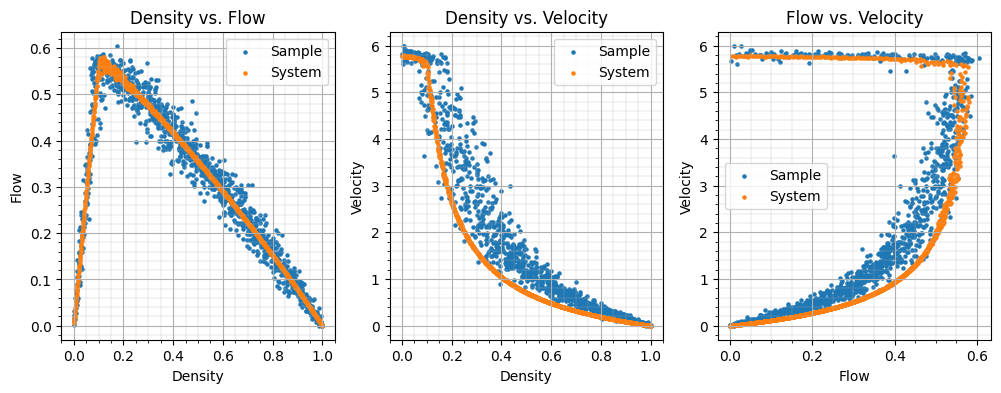

In [28]:
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=3)

# Density vs Flow
ax[0].scatter(sample_density_array, sample_flow_array, s=5, label="Sample")
ax[0].scatter(system_density_array, system_flow_array, s=5, label="System")

# Set titles and labels
ax[0].set_title("Density vs. Flow")
ax[0].set_xlabel("Density")
ax[0].set_ylabel("Flow")

# Density vs Speed
ax[1].scatter(sample_density_array, sample_velocity_array, s=5, label="Sample")
ax[1].scatter(system_density_array, system_velocity_array, s=5, label="System")

# Set titles and labels
ax[1].set_title("Density vs. Velocity")
ax[1].set_xlabel("Density")
ax[1].set_ylabel("Velocity")

# Flow vs Speed
ax[2].scatter(sample_flow_array, sample_velocity_array, s=5, label="Sample")
ax[2].scatter(system_flow_array, system_velocity_array, s=5, label="System")

# Set titles and labels
ax[2].set_title("Flow vs. Velocity")
ax[2].set_xlabel("Flow")
ax[2].set_ylabel("Velocity")

# Set grids, ticks and legends
for i in ax:
    i.grid(which='major')
    i.grid(which='minor', linewidth=0.2)
    i.minorticks_on()
    i.legend()